# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb)
* [imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

In [20]:
model_checkpoint = "microsoft/swin-base-patch4-window12-384" # pre-trained model from which to fine-tune
batch_size = 128 # batch size for training and evaluation

Before we start, let's install the `datasets`, `transformers` and `accelerate` libraries.

In [7]:
!pip install -q datasets transformers accelerate evaluate

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
!pip install ipywidgets widgetsnbextension pandas-profiling

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 119.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 69.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=7182d38cb2736c7812250fd2a7400eb5b73a067fe7e7c1ee23720084e5bdd445
  Stored in directory: /home/hice1/wchia7/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding th

In [2]:
pip list 

Package                           Version
--------------------------------- ---------------
accelerate                        1.5.2
aiofiles                          22.1.0
aiohappyeyeballs                  2.6.1
aiohttp                           3.11.14
aiosignal                         1.3.2
aiosqlite                         0.18.0
anaconda-anon-usage               0.4.3
anaconda-client                   1.11.2
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.0
anaconda-project                  0.11.1
annotated-types                   0.7.0
anyio                             3.5.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
async-timeout                     5.0.1
attrs                             22.1.0
Babel                             2.11.0
backcall                          0.2.0
backports.functool

Note: you may need to restart the kernel to use updated packages.


## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument.

In [3]:
!realpath ../Dataset/yolo_training/cropped_lizard_10000


/storage/ice1/6/5/wchia7/Anole_classifier/Dataset/yolo_training/cropped_lizard_10000


In [4]:
from datasets import load_dataset

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
dataset = load_dataset("../Dataset/yolo_training/cropped_lizard_10000")

Resolving data files:   0%|          | 0/8108 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [5]:
import evaluate
metric = evaluate.load("accuracy")

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8108
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [7]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x320>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [8]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['bark_anole', 'brown_anole', 'crested_anole', 'green_anole', 'knight_anole'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

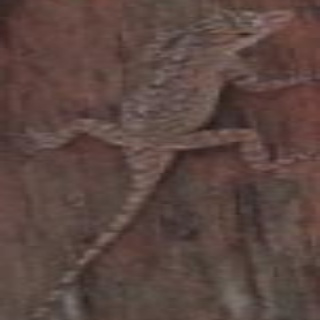

In [9]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

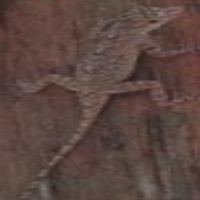

In [10]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [11]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [12]:
dataset["train"].features["label"]

ClassLabel(names=['bark_anole', 'brown_anole', 'crested_anole', 'green_anole', 'knight_anole'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [13]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'crested_anole'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [14]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast=True)
image_processor

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 384,
    "width": 384
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [15]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [16]:
# split up training into training + validation
train_ds = dataset['train']
val_ds = dataset['validation']

In [17]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [18]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x320>,
 'label': 0,
 'pixel_values': tensor([[[ 0.2111,  0.2282,  0.1254,  ...,  0.6906,  0.8276,  0.8961],
          [ 0.1426,  0.1597,  0.0569,  ...,  0.7591,  0.8447,  0.8789],
          [ 0.0569,  0.0569, -0.0458,  ...,  0.8447,  0.8447,  0.8618],
          ...,
          [-0.4568, -0.4397, -0.4568,  ...,  0.9474,  1.0159,  1.0502],
          [-0.3883, -0.3883, -0.3883,  ...,  1.0502,  1.1358,  1.1700],
          [-0.3198, -0.3369, -0.3198,  ...,  1.1358,  1.2214,  1.2557]],
 
         [[ 0.1877,  0.2052,  0.1001,  ...,  0.8179,  0.9580,  1.0280],
          [ 0.1176,  0.1352,  0.0301,  ...,  0.8880,  0.9755,  1.0105],
          [ 0.0301,  0.0301, -0.0749,  ...,  0.9755,  0.9755,  0.9930],
          ...,
          [-0.5126, -0.4951, -0.5126,  ...,  1.0105,  1.0980,  1.1331],
          [-0.4426, -0.4251, -0.4251,  ...,  1.1331,  1.2206,  1.2556],
          [-0.3725, -0.3550, -0.3375,  ...,  1.2206,  1.3081,  1.3431]]

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head.

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window12-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [21]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-lizard-class-swin-base",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [22]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [23]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [25]:
!nvidia-smi

Sat Mar 29 19:59:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:C0:00.0 Off |                    0 |
| N/A   32C    P0            114W /  700W |     876MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [26]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.604500,1.372822,0.491000
2,0.996000,0.507802,0.820000
3,0.632400,0.305537,0.890000
4,0.410100,0.237852,0.910000
5,0.324200,0.190287,0.930000
6,0.265100,0.176797,0.939000
7,0.238500,0.169174,0.936000
8,0.218300,0.161889,0.944000
9,0.206500,0.156332,0.940000
10,0.182400,0.157885,0.939000


***** train metrics *****
  epoch                    =          30.0
  total_flos               = 52240633042GF
  train_loss               =        0.2494
  train_runtime            =    0:52:45.49
  train_samples_per_second =        76.841
  train_steps_per_second   =         0.152


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [27]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       30.0
  eval_accuracy           =      0.961
  eval_loss               =     0.1457
  eval_runtime            = 0:00:06.11
  eval_samples_per_second =    163.647
  eval_steps_per_second   =      1.309


Looks like our model got it correct!

## Validate on Test Dataset


In [28]:
from transformers import pipeline

pipe = pipeline("image-classification", "swin-base-patch4-window12-384-finetuned-lizard-class-swin-base")

Device set to use cuda:0


In [29]:
# Get test dataset example
test_dataset = dataset["test"]

In [30]:
test_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['bark_anole', 'brown_anole', 'crested_anole', 'green_anole', 'knight_anole'], id=None)}

### Example: Classification on 1 image

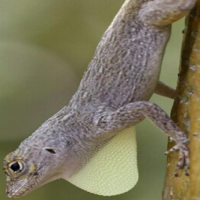

In [8]:
image = test_dataset[0]
image["image"].resize((200, 200))

In [9]:
target_image = image["image"]

In [10]:
pipe(target_image)

[{'label': 'bark_anole', 'score': 0.9999055862426758},
 {'label': 'crested_anole', 'score': 4.0646893467055634e-05},
 {'label': 'green_anole', 'score': 3.137885869364254e-05},
 {'label': 'knight_anole', 'score': 1.5742103641969152e-05},
 {'label': 'brown_anole', 'score': 6.725816092512105e-06}]

### Classification on test dataset

In [31]:
from evaluate import evaluator

task_evaluator = evaluator("image-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=test_dataset,
    metric= "accuracy",
    label_mapping=pipe.model.config.label2id
)

eval_results

{'accuracy': 0.939,
 'total_time_in_seconds': 23.20816064393148,
 'samples_per_second': 43.08829188759869,
 'latency_in_seconds': 0.02320816064393148}

### Evaluation with Confusion Matrix

In [32]:
# Get class names mapping
label_names = test_dataset.features["label"].names

# Create a mapping from label names to indices
label_to_idx = {name: idx for idx, name in enumerate(label_names)}

# Prepare predictions and references
def predict_image(image):
    preds = pipe(image)
    name = preds[0]["label"]
    idx = label_to_idx[name]
    return idx  # Get the top prediction

# Get predicted labels
predictions_int = [predict_image(item["image"]) for item in test_dataset]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [33]:
# Get ground truth labels
references_int = [item["label"] for item in test_dataset]

In [34]:
#Check predictions / ground truth labels
references_int

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [35]:
import evaluate 

# Compute confusion matrix
conf_matrix = evaluate.load("confusion_matrix")
results = conf_matrix.compute(predictions=predictions_int, references=references_int)

# Print confusion matrix results
print(results)

{'confusion_matrix': array([[185,   4,   6,   2,   3],
       [  3, 188,   8,   1,   0],
       [  7,  12, 179,   2,   0],
       [  0,   5,   0, 194,   1],
       [  1,   2,   0,   4, 193]])}


### Compute f1-score, precision and recall for each Anole class

In [36]:
# Compute precision, recall, and F1-score
metric = evaluate.combine(["precision", "recall", 'f1'])
prf_results = metric.compute(predictions=predictions_int, references=references_int, average=None)  # No averaging, get per-class metrics

# Print per-class precision, recall, and F1-score
for i, class_name in enumerate(label_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {prf_results['precision'][i]:.4f}")
    print(f"  Recall: {prf_results['recall'][i]:.4f}")
    print(f"  F1-score: {prf_results['f1'][i]:.4f}")
    print("-" * 30)


Class: bark_anole
  Precision: 0.9439
  Recall: 0.9250
  F1-score: 0.9343
------------------------------
Class: brown_anole
  Precision: 0.8910
  Recall: 0.9400
  F1-score: 0.9148
------------------------------
Class: crested_anole
  Precision: 0.9275
  Recall: 0.8950
  F1-score: 0.9109
------------------------------
Class: green_anole
  Precision: 0.9557
  Recall: 0.9700
  F1-score: 0.9628
------------------------------
Class: knight_anole
  Precision: 0.9797
  Recall: 0.9650
  F1-score: 0.9723
------------------------------


### Visualize Confusion Matrix (Absolute Numbers)

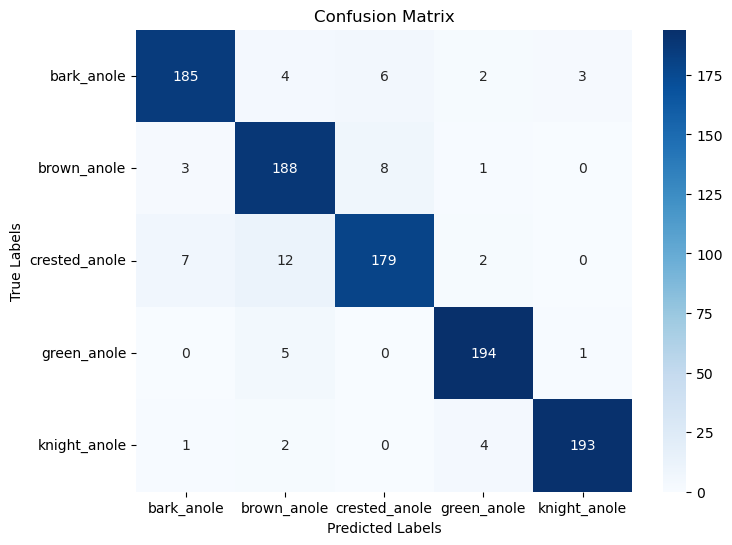

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array
conf_matrix = np.array(results["confusion_matrix"])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.features["label"].names, yticklabels=test_dataset.features["label"].names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Visualize Confusion Matrix (Normalized)

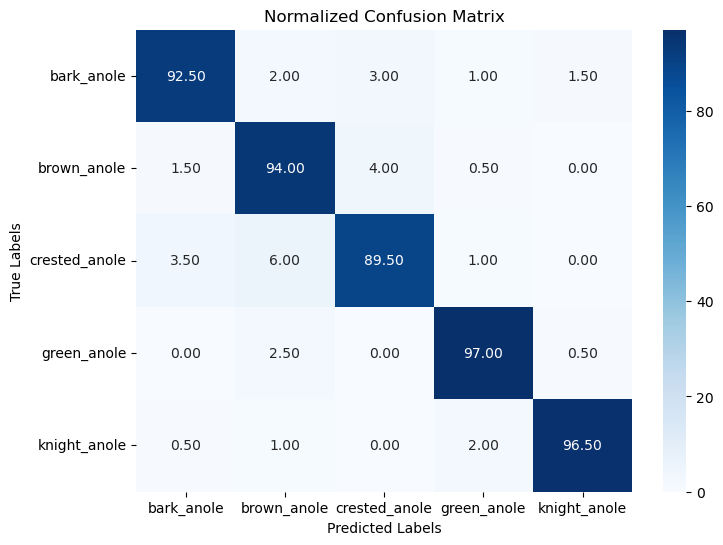

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array
conf_matrix = np.array(results["confusion_matrix"])

conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)

# Ensure NaNs (if any row sums to 0) are replaced with 0
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_normalized * 100,  # Convert to percentage
    annot=True, fmt=".2f", cmap="Blues",
    xticklabels=label_names, yticklabels=label_names
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()